In [1]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import collections
from functools import partial
from os.path import expanduser
from tqdm import tqdm

from surround.image_processing import *
from surround.data_handling import *
from surround.efficient_coding import *
from aesthetics.plotting import *
from surround.modeling import gaussian, difference_of_gaussians

import pyret.filtertools as ft
from sklearn.decomposition import PCA
from scipy.stats import sem
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import interp1d

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('deepretina')

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Changes from previous versions:
- Constrain spacing by photoreceptor spacing
- Constrain width by visual field of salamander retina  
- Constrain output power instead of output variance

In [2]:
microns_per_degree = 50.0 # depends on species; this is for salamander
photoreceptor_width = 10.0/microns_per_degree # salamander photoreceptors have width of 10-20 microns
retina_width = 4000.0/microns_per_degree # salamander retina is about 4 mm
frequency_spacing = 1./retina_width # this is the lowest non-DC frequency we can estimate
highest_frequency = 0.5/photoreceptor_width # this is the highest frequency we can estimate (Nyquist freq.)

N = retina_width//photoreceptor_width
freqs = np.linspace(0, highest_frequency, N//2 + 1)
space = np.concatenate([np.linspace(-0.5*retina_width, 0, N//2 + 1)[:-1], np.linspace(0, 0.5*retina_width, N//2 + 1)])

### Load receptive fields

In [3]:
# These are loaded as (space, receptive) field tuples
cells = {}
cells['ganglion'] = load_ganglion_cells(space_mode='peak')
cells['bipolar'] = load_bipolar_cells(space_mode='peak')
cells['amacrine'] = load_amacrine_cells(space_mode='peak')
cells['horizontal'] = load_horizontal_cells(space_mode='peak')

In [4]:
receptive_fields = collections.defaultdict(list)
for c in cells.keys():
    for s, rf in cells[c]:
        this_cell_interp = interp1d(s, rf, kind='slinear', bounds_error=False, fill_value=[0])
        receptive_fields[c].append(this_cell_interp(space))
        
average_ganglion_rf = np.mean(receptive_fields['ganglion'], axis=0)

### Compute projective fields

In [5]:
horz_pfs_full = get_horizontal_projective_field(conv_mode='full')
horz_pfs_same = get_horizontal_projective_field(conv_mode='same')
ama_pfs_full = get_amacrine_projective_field(conv_mode='full')
ama_pfs_same = get_amacrine_projective_field(conv_mode='same')

space_h_full, horz_pf_full, horz_sem_full = get_mean(horz_pfs_full)
space_h_same, horz_pf_same, horz_sem_same = get_mean(horz_pfs_same)
space_a_full, ama_pf_full, ama_sem_full = get_mean(ama_pfs_full)
space_a_same, ama_pf_same, ama_sem_same = get_mean(ama_pfs_same)

In [6]:
horz_pf_interp = interp1d(space_h_full, horz_pf_full, kind='slinear', bounds_error=False, fill_value=[0])
ama_pf_interp = interp1d(space_a_full, ama_pf_full, kind='slinear', bounds_error=False, fill_value=[0])

horz_pf = horz_pf_interp(space)
ama_pf = ama_pf_interp(space)

### Signal

In [7]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = expanduser('~/data/images/Tkacik/cd01A')
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)
signal_amps, signal_freqs, signal_sem = averageAmplitudeSpectrum2d(patches, spacing=spacing)

Only 70 files in directory.


In [8]:
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers

popt_signal, pcov  = curve_fit(func, signal_freqs[1:], signal_amps[1:])
print(popt_signal)
signal = func(freqs, *popt_signal)
signal[0] = np.sqrt(np.sum(signal[1:]))

[ 0.0056951   1.01550079]


/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


### Noise  
Note that the amplitude of the average_ganglion_fft will change the SNR. As the amplitude $\rightarrow \infty$, we get $$\rm{SNR} \rightarrow \frac{\sum (\rm{filter}_{1:f} \times \rm{signal}_{1:f})^2}{\sum (\rm{filter}_{1:f} \times N_{\rm{in}})^2}$$.  

Since the scale of the ganglion fft is arbitrary, we can look at the SNR in this limit.

In [9]:
input_noise = 0.098762200628786892
output_noise = 0.35
target_power = 54.131410989171826

1.92576130327


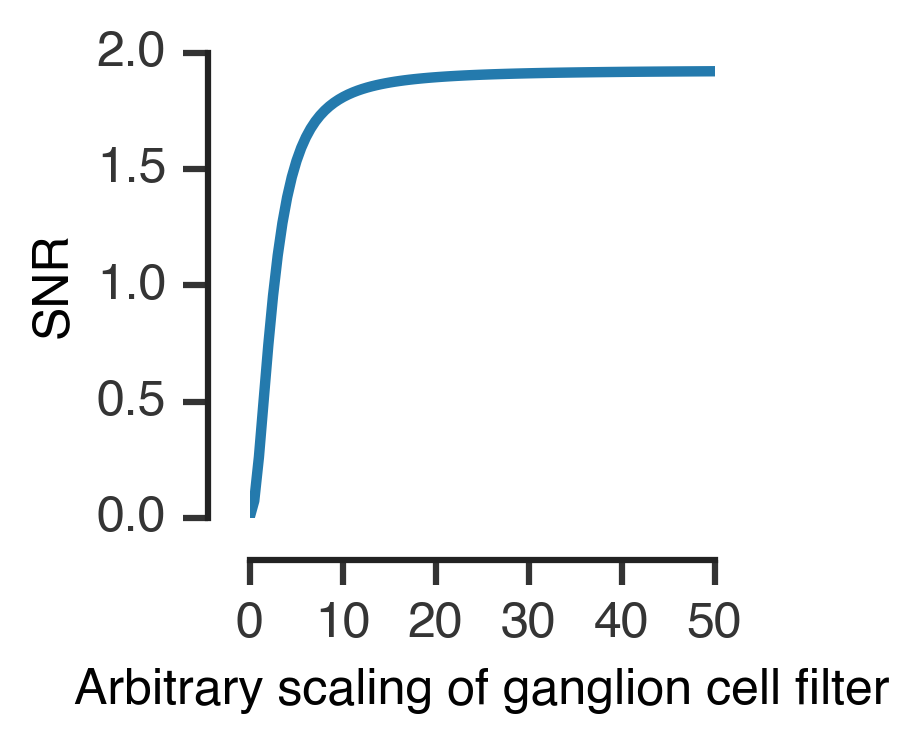

In [10]:
fig = plt.gcf()
fig.set_size_inches((2,2))
average_ganglion_fft = abs(np.fft.rfft(average_ganglion_rf))
print(get_snr(input_noise, output_noise, signal, 1000*average_ganglion_fft, mode='variance'))
snrs = [get_snr(input_noise, output_noise, signal, c*average_ganglion_fft) for c in np.linspace(0,50,100)]
plt.plot(np.linspace(0,50,100), snrs)
adjust_spines(plt.gca())
plt.xlabel('Arbitrary scaling of ganglion cell filter')
plt.ylabel('SNR')

In [11]:
# SNR = 0.269 is total SNR from ganglion recordings of 112 repeats to 30 seconds natural scenes
def find_filt_const(filt_const):
    this_snr = get_snr(input_noise, output_noise, signal, filt_const*average_ganglion_fft, mode='variance')
    return (this_snr - 0.26912469)**2

filt_const_opt = scipy.optimize.minimize_scalar(find_filt_const)

print(get_snr(input_noise, output_noise, signal, filt_const_opt.x*average_ganglion_fft, mode='variance'))

0.269124689452


### Ideal filter

In [12]:
ideal_filter = unique_soln(signal**2, input_noise, output_noise)

The relative error from this choice of Lagrangian multiplier is 2.89775914924e-07.


### Model of Horizontal Projective Field + Amacrine Projective Field + Center

In [13]:
horz_pf /= np.sum(horz_pf)
ama_pf /= np.sum(ama_pf)

Load David's 1721 ganglion cells

In [14]:
data_path = expanduser('~/data/kastner/receptive_fields/')
spatialDelta = 0.05 # mm
micronsPerDeg = 50.
ganglion_rfs = {
    'fast_on': np.loadtxt(data_path + 'linesRF1.txt').reshape((126, 101, -1)),
    'fast_off_adapting': np.loadtxt(data_path + 'linesRF19.txt').reshape((-1, 101, 96)),
    'fast_off_sensitizing': np.loadtxt(data_path + 'linesRF8.txt').reshape((-1, 101, 96)),
    'medium_off_adapting': np.loadtxt(data_path + 'linesRF29.txt').reshape((-1, 101, 96)),
    'slow_off': np.loadtxt(data_path + 'linesRF17.txt').reshape((-1, 101, 96)),
}

In [15]:
for celltype in ganglion_rfs.keys():
    for rf in ganglion_rfs[celltype]:
        # since receptive fields are noisy, use PCA
        pca = PCA(n_components=2)
        pca.fit(rf)
        g_pca = pca.components_[0]

        sign_of_pc = -1 * np.sign(g_pca[abs(g_pca) == np.max(abs(g_pca))])
        this_space = get_space(g_pca, spatialDelta, micronsPerDeg, kind='peak')
        
        rf_interp = interp1d(this_space, sign_of_pc*g_pca, kind='slinear', bounds_error=False, fill_value=[0])

        receptive_fields[celltype].append(rf_interp(space))

Get center widths for each celltype

In [16]:
diff_of_gauss_mu0 = partial(difference_of_gaussians, mu=0)

In [17]:
def center_and_surround(space, center_width, surround_width, center_strength, surround_strength):
    return diff_of_gauss_mu0(space, abs(center_width), abs(surround_width),
                            -abs(center_strength), abs(surround_strength))

In [18]:
center_widths = collections.defaultdict(list)
surround_widths = collections.defaultdict(list)
center_strengths = collections.defaultdict(list)
surround_strengths = collections.defaultdict(list)
fit_failures = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        
        for idg, g in tqdm(enumerate(receptive_fields[celltype])):
            try:
                popt_this, pcov = curve_fit(center_and_surround, space, g, p0=[1.5, 3.5, -10, 30])
                center_id = np.argmin(abs(popt_this[:2]))
                surround_id = 1 ^ center_id
                center_widths[celltype].append(abs(popt_this[center_id]))
                surround_widths[celltype].append(abs(popt_this[surround_id]))
                center_strengths[celltype].append(popt_this[center_id+2])
                surround_strengths[celltype].append(popt_this[surround_id+2])
#                 plt.plot(space, diff_of_gauss_mu0(space, *popt_this), color=np.random.rand(3), alpha=0.6)
            except:
                fit_failures[celltype].append(idg)
            
                # just set params to median across cells
                # this way the params are still aligned with the receptive field id
                center_widths[celltype].append(np.median(center_widths[celltype]))
                surround_widths[celltype].append(np.median(surround_widths[celltype]))
                center_strengths[celltype].append(np.median(center_strengths[celltype]))
                surround_strengths[celltype].append(np.median(surround_strengths[celltype]))
                
#                 print("Couldn't fit cell %d" %idg)

321it [00:43, 10.58it/s]
772it [01:19, 13.50it/s]
126it [00:27,  6.27it/s]
253it [01:36,  2.63it/s]
28it [00:08,  1.31it/s]
249it [00:50,  5.84it/s]


In [19]:
for f in fit_failures.keys():
    print("couldn't fit %d in %s" %(len(fit_failures[f]), f))

couldn't fit 6 in medium_off_adapting
couldn't fit 4 in fast_off_adapting
couldn't fit 9 in fast_off_sensitizing
couldn't fit 5 in fast_on
couldn't fit 31 in slow_off
couldn't fit 3 in ganglion


Plot the average profile across celltypes

In [20]:
median_center_widths = {}
for celltype in center_widths.keys():
    cws = np.array(center_widths[celltype])
    sws = np.array(surround_widths[celltype])
    css = np.array(center_strengths[celltype])
    sss = np.array(surround_strengths[celltype])
#     mean_center_widths[celltype] = np.mean(cws[cws < 500])
#     mean_surround_width = np.mean(sws[sws < 500])
#     mean_center_strength = np.mean(css[abs(css) < 500])
#     mean_surround_strength = np.mean(sss[abs(sss) < 500])
    
    median_center_widths[celltype] = np.median(abs(cws))
    median_surround_width = np.median(abs(sws))
    median_center_strength = np.median(-abs(css))
    median_surround_strength = np.median(abs(sss))
#     plt.plot(space, diff_of_gauss_mu0(space, median_center_widths[celltype], median_surround_width,
#                                      median_center_strength, median_surround_strength), label=celltype)
# plt.legend(frameon=False, fontsize=9, loc='lower left')
# adjust_spines(plt.gca())

In [21]:
median_center_widths

{'fast_off_adapting': 1.6921005125265909,
 'fast_off_sensitizing': 2.0658102863813603,
 'fast_on': 1.9647399365227634,
 'ganglion': 1.3731413954345983,
 'medium_off_adapting': 1.5794333062701262,
 'slow_off': 1.5642116410053606}

Bar charts to visualize diversity

## Run info maps

In [22]:
resolution = 150
horz_weights = np.linspace(0,1,resolution)
center_weights = np.linspace(0,1,resolution)

In [23]:
init_filt_const = 10.9
info_maps = collections.defaultdict(list) # one info map per celltype (since they will be a function of center width)
failures = collections.defaultdict(list)
detailed_failures = collections.defaultdict(list)
for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']:
        center = gaussian(x=space, sigma=median_center_widths[celltype], mu=0.)
        center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf
        
        def rf_model(horz_weight, center_weight):
            return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
        
#         print('Information map for %s cells.' %celltype)
        
        infomap = np.zeros((resolution, resolution))
        for idh,hw in tqdm(enumerate(horz_weights)):
            for idc,cw in enumerate(center_weights):
                rf = rf_model(hw, cw)
                rf_filt = abs(np.fft.rfft(rf))
                
                # constrain model
                def constrain_filt_power(filt_const):
                    size = len(rf_filt)
                    output_power = np.sum((signal*filt_const*rf_filt)**2 
                                          + (input_noise*filt_const*rf_filt)**2
                                          + output_noise**2)
                    
                    return (target_power - output_power)**2

                filt_const_opt = scipy.optimize.minimize(constrain_filt_power, init_filt_const)
                iterations = 0
                new_init_filt_const = init_filt_const
                while not filt_const_opt.success:
                    iterations += 1
                    new_init_filt_const *= 10
                    filt_const_opt = scipy.optimize.minimize(constrain_filt_power, new_init_filt_const)
                    if iterations > 10:
                        detailed_failures[celltype] = filt_const_opt
                        break
                
                filt_const = abs(filt_const_opt['x'])
                
                if not filt_const_opt.success:
                    failures[celltype].append([hw, cw])

                signal_power = (filt_const * rf_filt * signal)**2
                noise_power = (filt_const * rf_filt * input_noise)**2 + output_noise**2
                infomap[idh,idc] = 0.5*np.sum(np.log2(1 + signal_power/noise_power))
        info_maps[celltype] = infomap

150it [00:28,  5.40it/s]
150it [00:28,  5.40it/s]
150it [00:28,  5.40it/s]
150it [00:28,  5.41it/s]
150it [00:27,  5.37it/s]
150it [00:28,  5.42it/s]


## Fit cells to rf_model

In [24]:
iterations = 100

fits = collections.defaultdict(list)
mean_squared_errors = collections.defaultdict(list)
abs_errors = collections.defaultdict(list)
variances = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
                
        popts = []
        
#         print('Fitting ganglion celltype %s.' %celltype)
        for i,rf in tqdm(enumerate(receptive_fields[celltype])):
            center = gaussian(x=space, sigma=center_widths[celltype][i], mu=0.)
            center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

            def rf_model(horz_weight, center_weight):
                horz_weight = np.min([1.0, abs(horz_weight)])
                center_weight = np.min([1.0, abs(center_weight)])
                return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
            
            def model_error_to_ganglion_cells(weights):
                hw, cw = weights
                modeled_rf = rf_model(hw, cw)
                normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
                return sum(abs(normed_rf - rf))

            best_fit_err = np.inf
            for itr in range(iterations):
                this_popt = minimize(model_error_to_ganglion_cells, np.random.rand(2))
                if this_popt.fun < best_fit_err:
                    best_fit_err = this_popt.fun
                    popt = this_popt
            
            # get mean squared error
            modeled_rf = rf_model(*popt.x)
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            mse = np.mean((normed_rf - rf)**2)

            # truncate params between 0 and 1
#             x = np.where(popt.x < 0, 0, popt.x) # this actually is wrong, since I'm abs(params) in rf_model
#             x = np.where(x > 1, 1, x)
            x = np.where(abs(popt.x) > 1, 1, abs(popt.x))

            popts.append(x)
            abs_errors[celltype].append(popt.fun)
            mean_squared_errors[celltype].append(mse)
            variances[celltype].append(np.var(rf))

        fits[celltype] = np.stack(popts)

105it [02:05,  1.03s/it]/usr/local/lib/python3.4/dist-packages/scipy/optimize/optimize.py:898: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
321it [06:22,  1.06s/it]
681it [13:51,  1.12s/it]/usr/local/lib/python3.4/dist-packages/scipy/optimize/optimize.py:898: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
767it [15:38,  1.27s/it]/usr/local/lib/python3.4/dist-packages/scipy/optimize/optimize.py:898: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/usr/local/lib/python3.4/dist-packages/scipy/optimize/optimize.py:898: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
772it [15:45,  1.42s/it]
126it [01:40,  1.25it/s]
253it [04:15,  1.33s/it]
28it [00:28,  1.03s/it]
232it [02:45,  1.73it/s]/usr/local/lib/python3.4/dist-packages/scipy/optimize/optimize.py:898: RuntimeWarning: divide by zero encountere

## Cells on curves for different info maps

In [25]:
colorscheme = {
    'ganglion': 'k',
    'fast_off_sensitizing': 'r',
    'fast_off_adapting': 'g',
    'slow_off': 'y',
    'fast_on': 'b',
    'medium_off_adapting': 'c'
}

(0, 1.1)

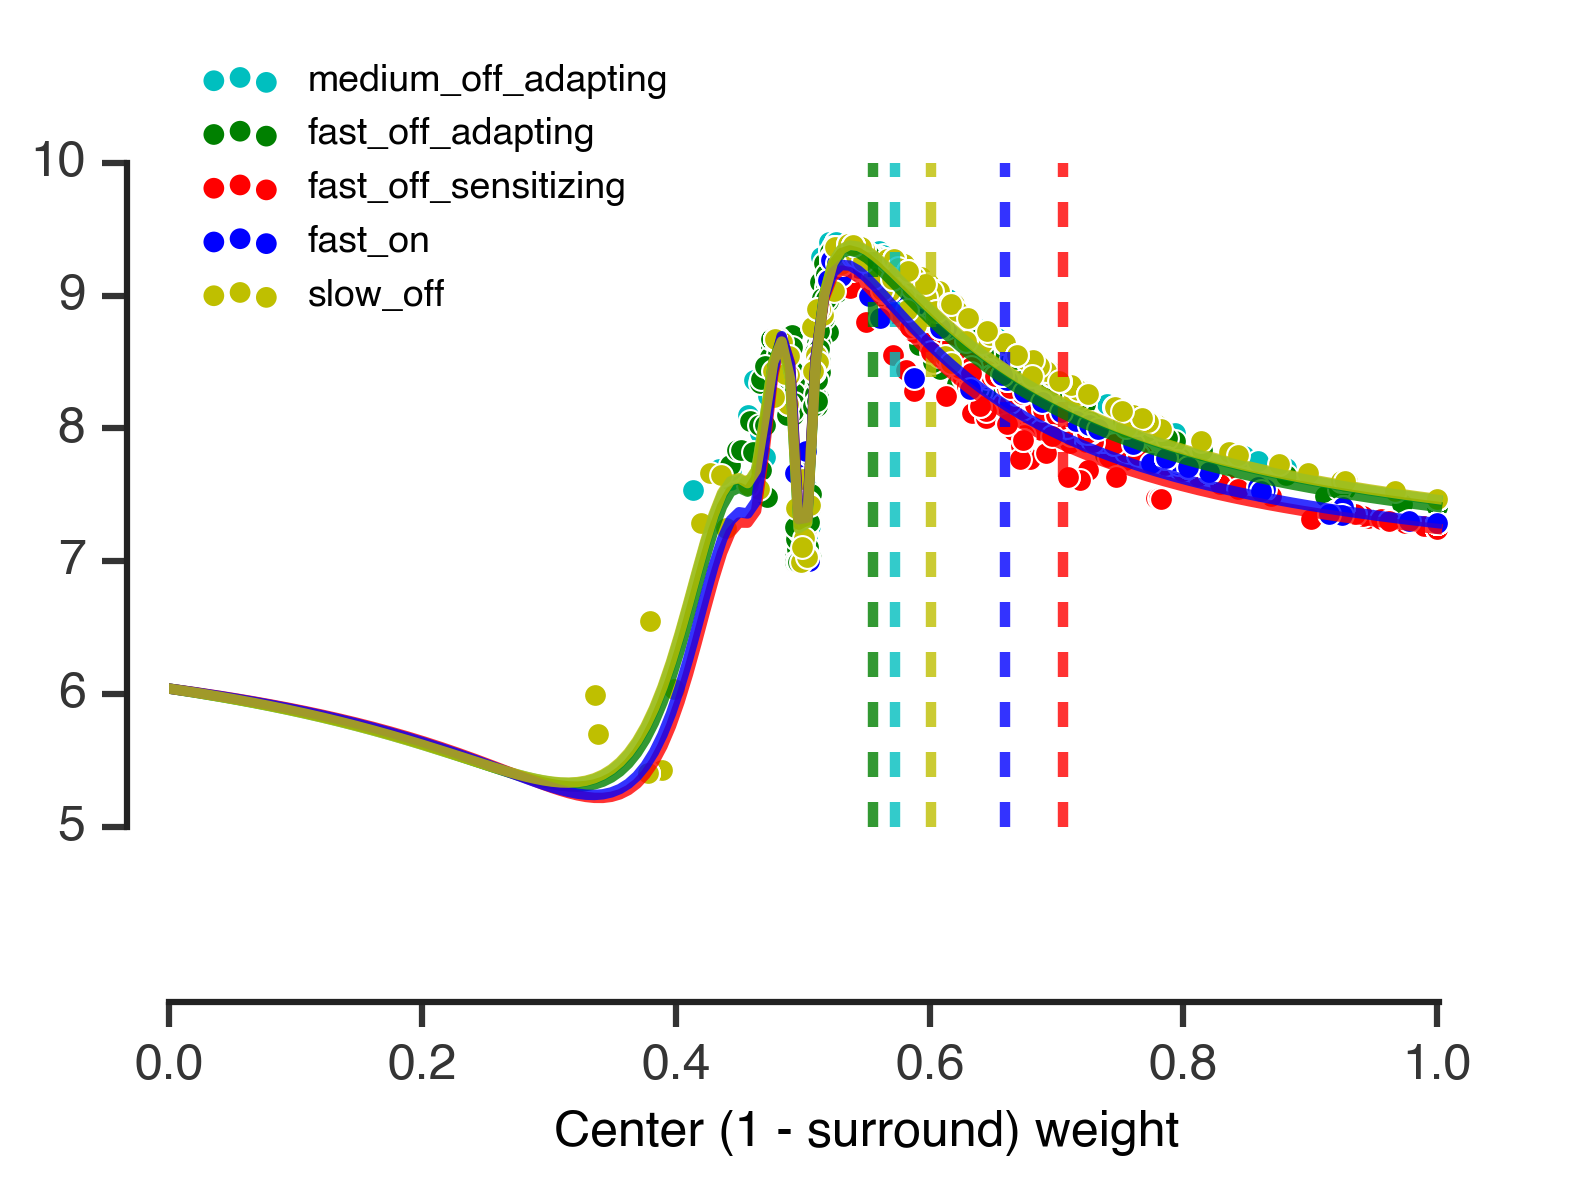

In [26]:
for c, celltype in enumerate(fits.keys()):
    if celltype != 'ganglion':
        plt.plot(center_weights, info_maps[celltype][75, :], alpha=0.8, color=colorscheme[celltype])
        infos_at_horz_slice = []
        center_weight_fits = np.stack(fits[celltype])[:, 1]
        for f in fits[celltype]:
            idx = np.argmin(abs(f[0] - horz_weights))
            idy = np.argmin(abs(f[1] - center_weights))
            infos_at_horz_slice.append(info_maps[celltype][idx, idy])

    #     color = np.random.rand(3)
        plt.scatter(center_weight_fits, infos_at_horz_slice, color=colorscheme[celltype], label=celltype, s=30, 
                    edgecolor='w', lw=0.5)
        plt.vlines(np.median(center_weight_fits), 5, 10, color=colorscheme[celltype], linestyle='--', alpha=0.8)
    

plt.legend(frameon=False, fontsize=9, loc='upper left')
plt.xlabel('Center (1 - surround) weight')
adjust_spines(plt.gca())
# plt.ylim(4.5, 9.8)
plt.xlim(0,1.1)

## Pick examples

### Pick the examples more quickly

In [29]:
nexamples = 10
example_models = collections.defaultdict(list)
example_ids = collections.defaultdict(list)

for celltype in receptive_fields.keys():
    if celltype in ['ganglion', 'fast_on', 'fast_off_adapting', 'fast_off_sensitizing', 
                    'medium_off_adapting', 'slow_off']: 
                
        for i,rf in tqdm(enumerate(receptive_fields[celltype])):
            center = gaussian(x=space, sigma=center_widths[celltype][i], mu=0.)
            center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

            def rf_model(horz_weight, center_weight):
                horz_weight = np.min([1.0, abs(horz_weight)])
                center_weight = np.min([1.0, abs(center_weight)])
                return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)
            
            def model_error_to_ganglion_cells(weights):
                hw, cw = weights
                modeled_rf = rf_model(hw, cw)
                normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
                return sum(abs(normed_rf - rf))

            x = fits[celltype][i]
            
            # get mean squared error
            modeled_rf = rf_model(*x)
            normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
            mse = np.mean((normed_rf - rf)**2)
            
            # collect examples
            if len(example_models[celltype]) <= nexamples:
                # check if the fit is close to the optimimum center weight
                if abs(x[1] - center_weights[np.argmax(np.max(info_maps[celltype], axis=0))]) < 0.03:
                    example_models[celltype].append(normed_rf)
                    example_ids[celltype].append(i)

321it [00:00, 946.06it/s]
772it [00:00, 1126.78it/s]
126it [00:00, 1087.90it/s]
253it [00:00, 1104.71it/s]
28it [00:00, 1060.00it/s]
249it [00:00, 1069.64it/s]


In [30]:
nexamples_for_this_plot = 10

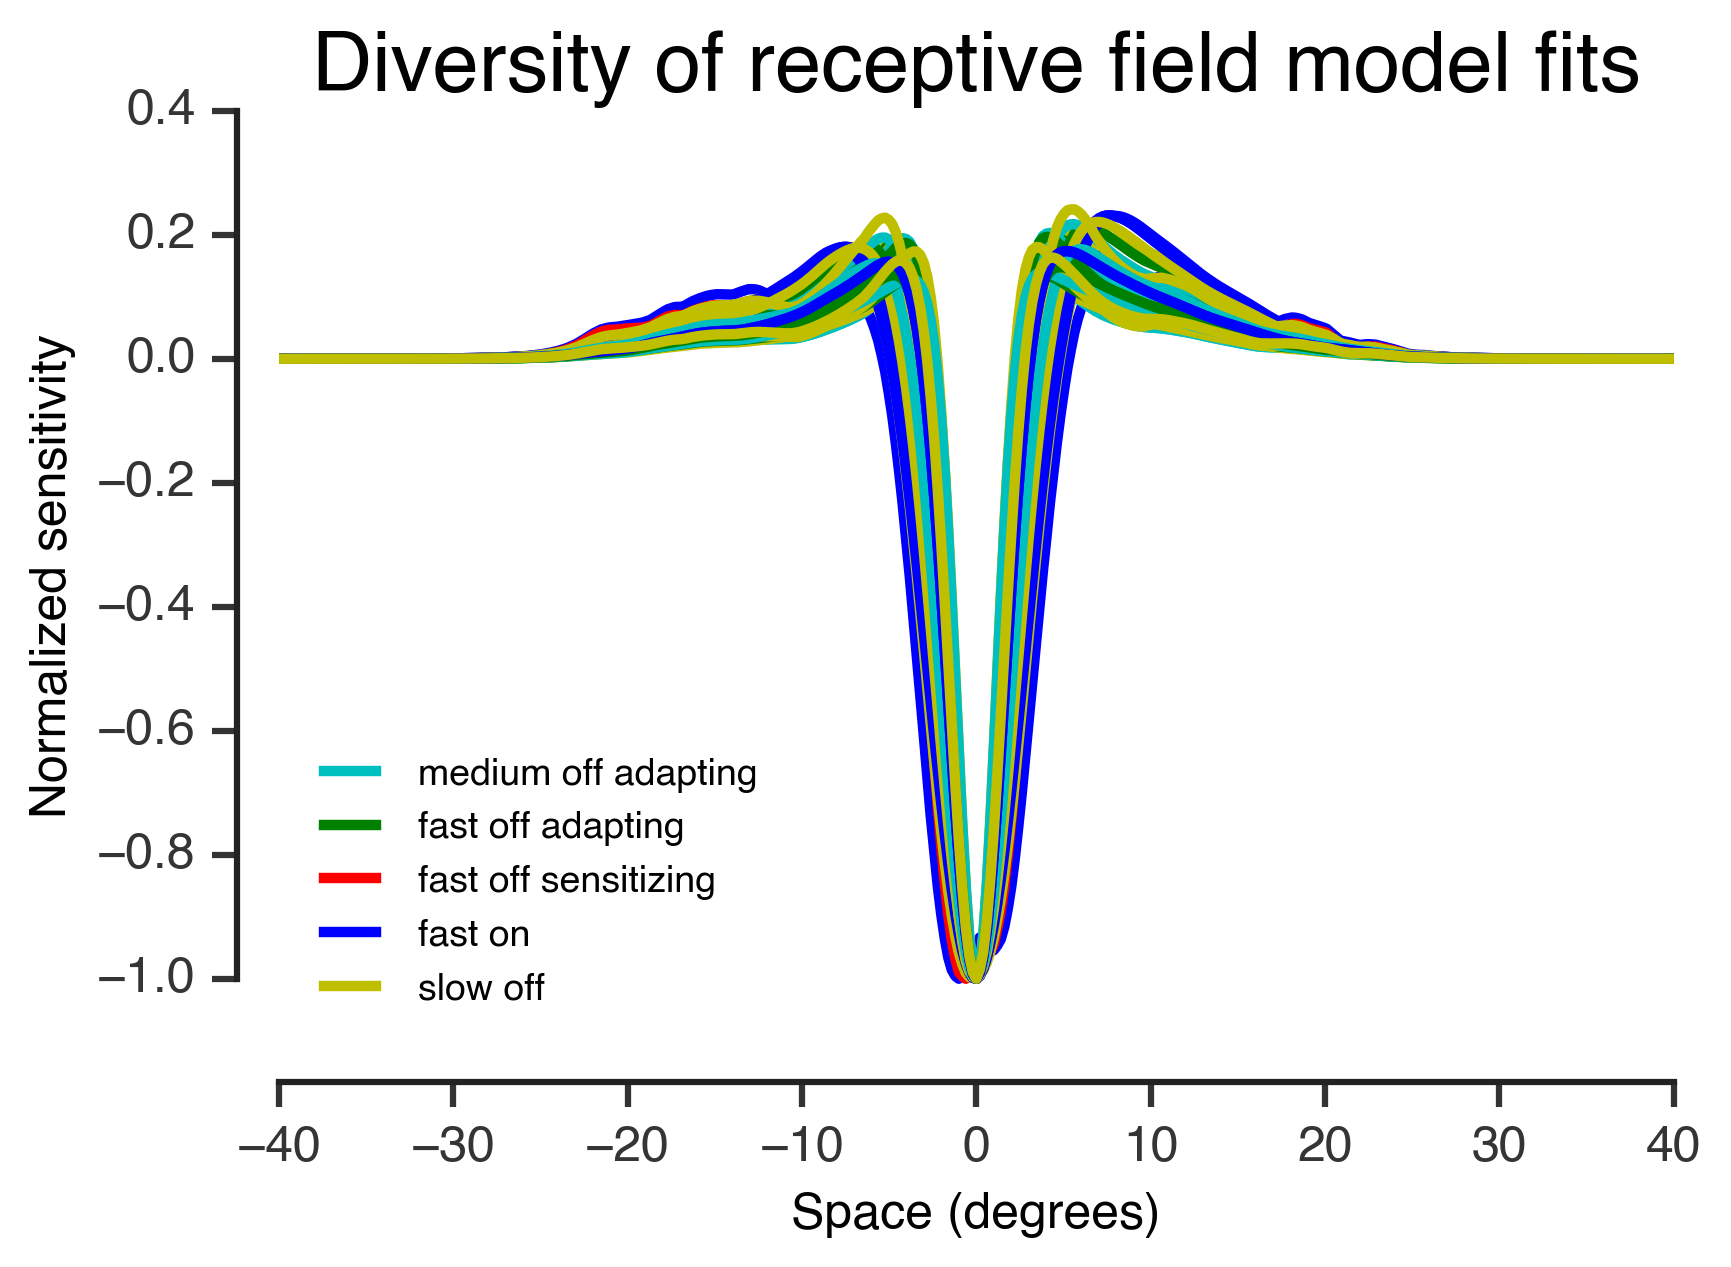

In [31]:
# celltype = 'fast_off_adapting'
for ide in range(nexamples_for_this_plot):
    for celltype in example_models.keys():
        if len(example_models[celltype]) > ide and celltype != 'ganglion':
            ex = example_models[celltype][ide]
            if ide == 0:
                plt.plot(space, ex/np.max(abs(ex)), alpha=1-ide/nexamples_for_this_plot, 
                         color=colorscheme[celltype], label=' '.join(celltype.split('_')))
            else:
                plt.plot(space, ex/np.max(abs(ex)), color=colorscheme[celltype])
            
plt.ylim(-1.1, 0.4)
plt.xlabel('Space (degrees)')
plt.ylabel('Normalized sensitivity')
plt.title('Diversity of receptive field model fits')
plt.legend(loc='lower left', frameon=False, fontsize=9)
adjust_spines(plt.gca())
plt.savefig('diversity of receptive fields in space peak with constrained noise rerun 1-21.png')

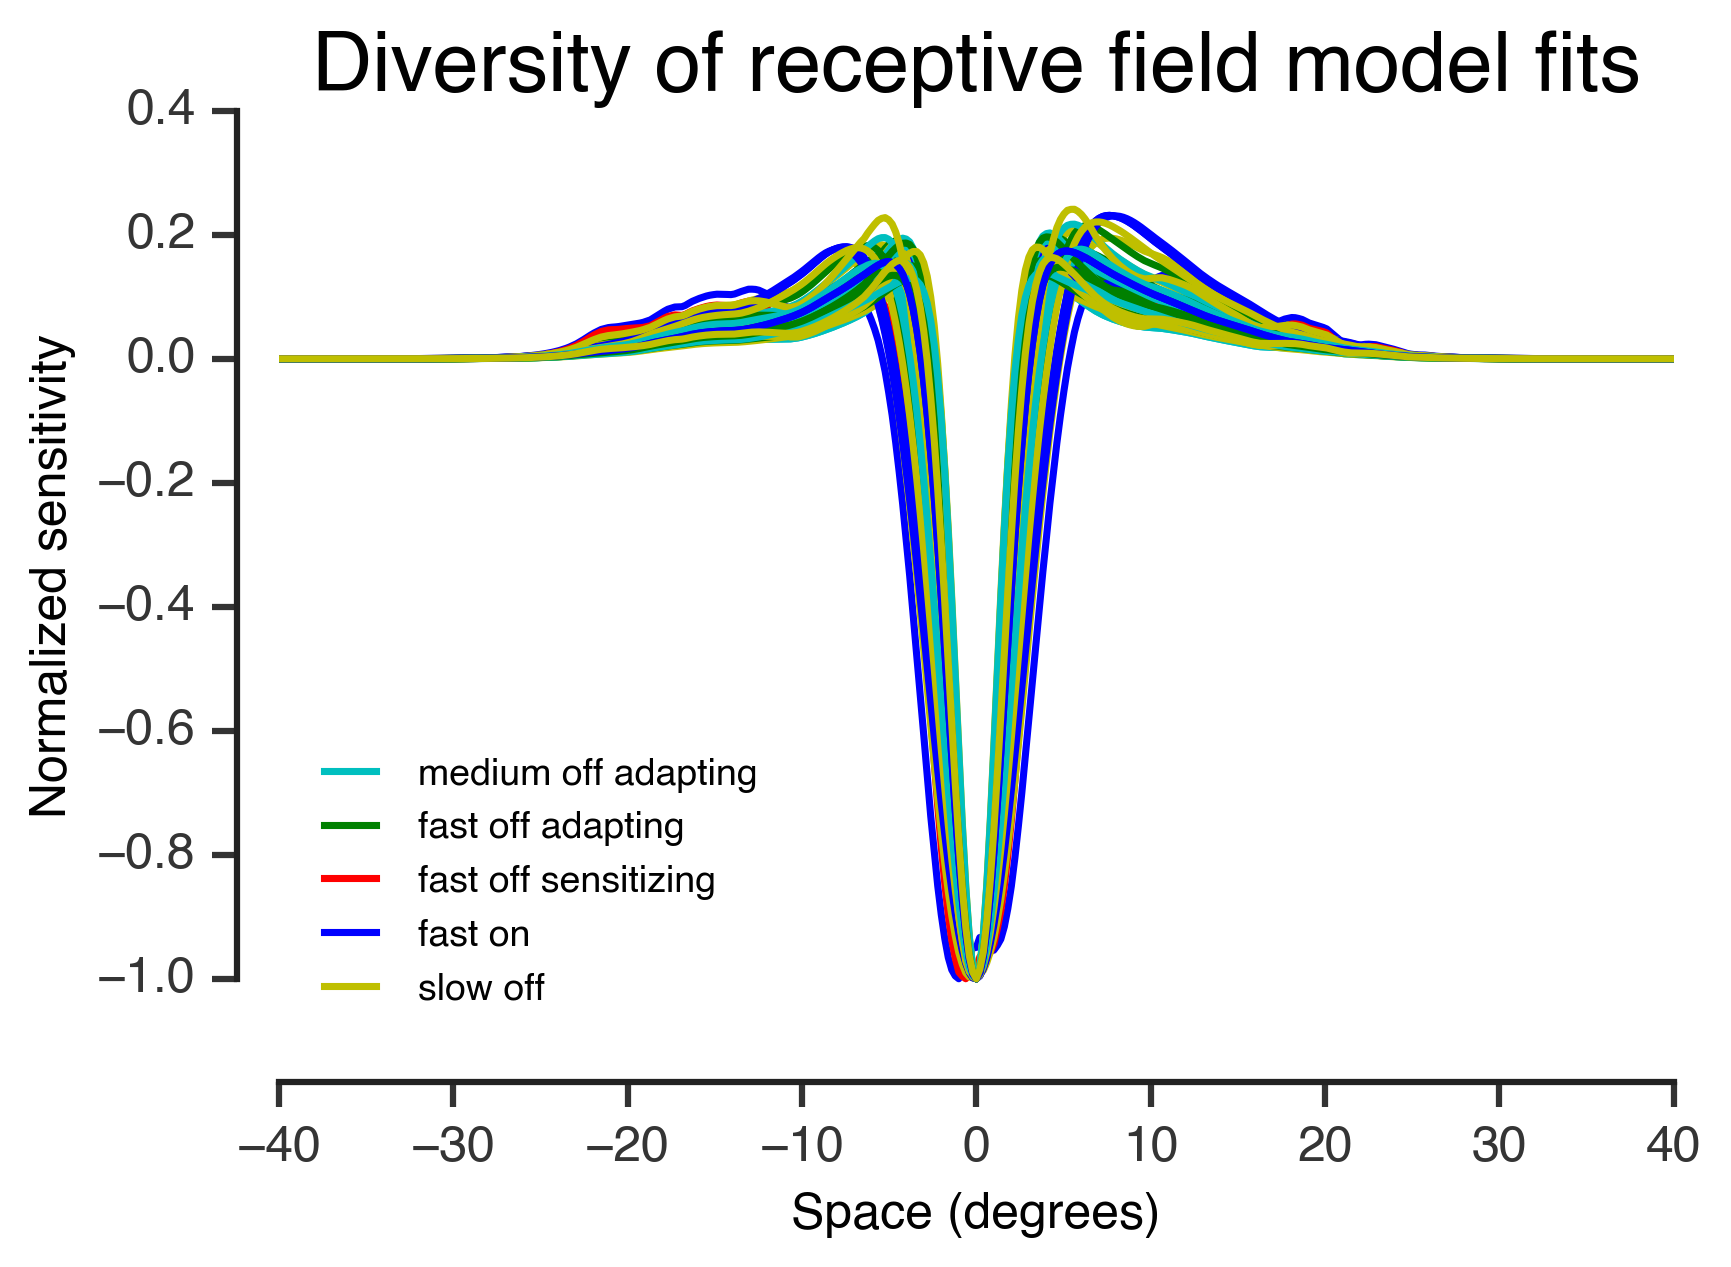

In [32]:
# celltype = 'fast_off_adapting'
for ide in range(nexamples_for_this_plot):
    for celltype in example_models.keys():
        if len(example_models[celltype]) > ide and celltype != 'ganglion':
            ex = example_models[celltype][ide]
            if ide == 0:
                plt.plot(space, ex/np.max(abs(ex)), alpha=1-ide/nexamples_for_this_plot, 
                         color=colorscheme[celltype], label=' '.join(celltype.split('_')), linewidth=1.7)
            else:
                plt.plot(space, ex/np.max(abs(ex)), color=colorscheme[celltype], linewidth=1.7)
            
plt.ylim(-1.1, 0.4)
plt.xlabel('Space (degrees)')
plt.ylabel('Normalized sensitivity')
plt.title('Diversity of receptive field model fits')
plt.legend(loc='lower left', frameon=False, fontsize=9)
adjust_spines(plt.gca())
plt.savefig('diversity of receptive fields in space lw17 peak with constrained noise rerun 1-21.png')

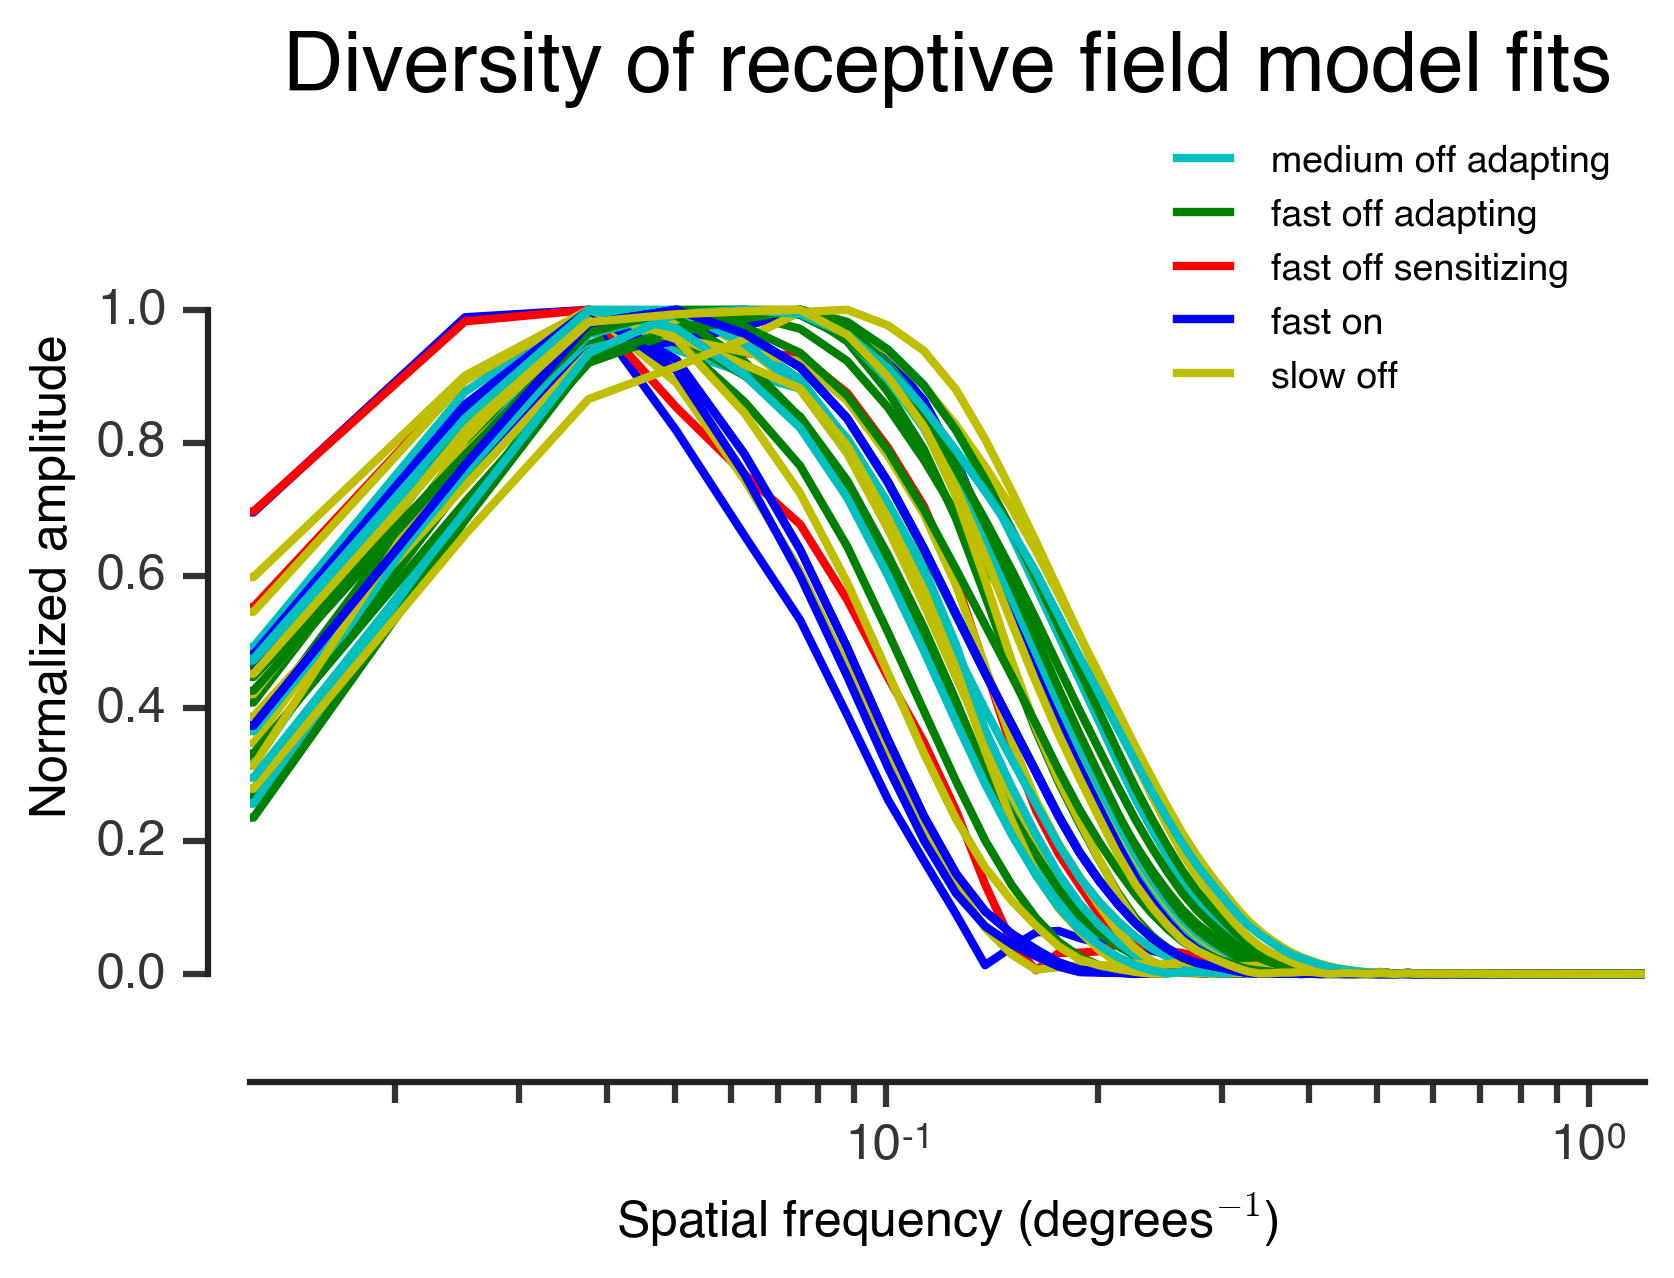

In [33]:
# celltype = 'fast_off_adapting'
for ide in range(nexamples_for_this_plot):
    for celltype in example_models.keys():
        if len(example_models[celltype]) > ide and celltype != 'ganglion':
            ex = example_models[celltype][ide]
            ex_fft = abs(np.fft.rfft(ex))
            if ide == 0:
                plt.plot(freqs, ex_fft/np.max(abs(ex_fft)), alpha=1-ide/nexamples_for_this_plot, 
                         color=colorscheme[celltype], label=' '.join(celltype.split('_')), linewidth=2)
            else:
                plt.plot(freqs, ex_fft/np.max(abs(ex_fft)),
                         color=colorscheme[celltype], linewidth=2)
            
plt.ylim(-0.1, 1.3)
plt.xlim(0.0124, 1.2)
plt.xscale('log')
plt.xlabel('Spatial frequency (degrees$^{-1}$)')
plt.ylabel('Normalized amplitude')
plt.title('Diversity of receptive field model fits')
plt.legend(loc='upper right', frameon=False, fontsize=9)
adjust_spines(plt.gca())
plt.savefig('diversity of receptive fields in freq logscale peak with constrained noise rerun 1-21.png')

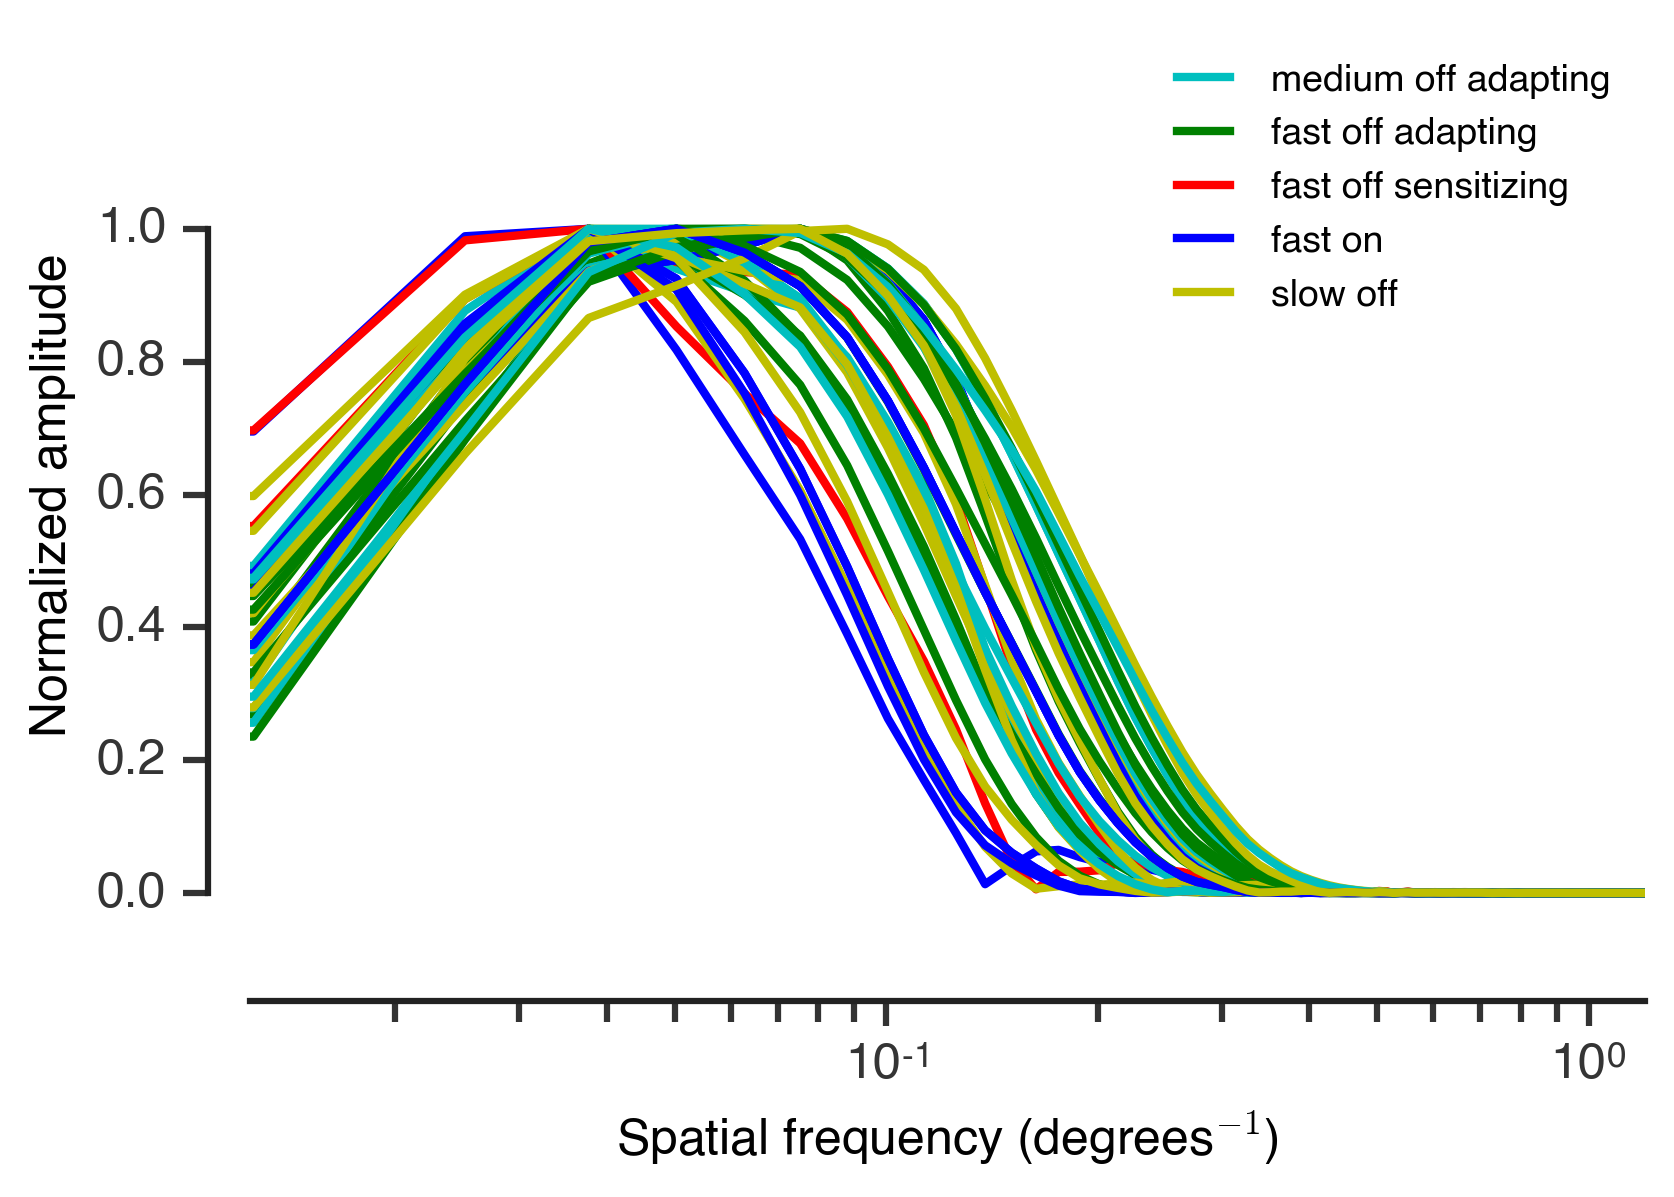

In [34]:
# celltype = 'fast_off_adapting'
for ide in range(nexamples_for_this_plot):
    for celltype in example_models.keys():
        if len(example_models[celltype]) > ide and celltype != 'ganglion':
            ex = example_models[celltype][ide]
            ex_fft = abs(np.fft.rfft(ex))
            if ide == 0:
                plt.plot(freqs, ex_fft/np.max(abs(ex_fft)), alpha=1-ide/nexamples_for_this_plot, 
                         color=colorscheme[celltype], label=' '.join(celltype.split('_')), linewidth=2)
            else:
                plt.plot(freqs, ex_fft/np.max(abs(ex_fft)),
                         color=colorscheme[celltype], linewidth=2)
            
plt.ylim(-0.1, 1.3)
plt.xlim(0.0124, 1.2)
plt.xscale('log')
plt.xlabel('Spatial frequency (degrees$^{-1}$)')
plt.ylabel('Normalized amplitude')
# plt.title('Diversity of receptive field model fits')
plt.legend(loc='upper right', frameon=False, fontsize=9)
adjust_spines(plt.gca())
plt.savefig('diversity of receptive fields in freq logscale peak no title with constrained noise rerun 1-21.png')

## Add ideal point

In [35]:
[np.mean(center_widths[celltype]) for celltype in center_widths.keys()]

[1.6654768012911039,
 1.7862833762386283,
 2.2033355145421663,
 2.178188312766427,
 1.6871825196323529,
 1.5905769640643554]

In [36]:
total_sum = sum([sum(center_widths[celltype]) for celltype in center_widths.keys()])
mean_center_width = total_sum/sum([len(center_widths[celltype]) for celltype in center_widths.keys()])
mean_center_width

1.83425067047514

In [37]:
rf = -np.fft.fftshift(np.fft.irfft(ideal_filter))
rf = np.append(rf, rf[-1])

center = gaussian(x=space, sigma=mean_center_width, mu=0.)
center /= -np.sum(center) # make center unit vector like horz_pf and ama_pf

def rf_model(horz_weight, center_weight):
    horz_weight = np.min([1.0, abs(horz_weight)])
    center_weight = np.min([1.0, abs(center_weight)])
    return center_weight*center + (1-center_weight)*(horz_weight*horz_pf + (1-horz_weight)*ama_pf)

def model_error_to_ganglion_cells(weights):
    hw, cw = weights
    modeled_rf = rf_model(hw, cw)
    normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
    return sum(abs(normed_rf - rf))

best_fit_err = np.inf
for itr in range(iterations):
    this_popt = minimize(model_error_to_ganglion_cells, np.random.rand(2))
    if this_popt.fun < best_fit_err:
        best_fit_err = this_popt.fun
        popt = this_popt

# get mean squared error
modeled_rf = rf_model(*popt.x)
normed_rf = np.max(abs(rf))*modeled_rf/np.max(abs(modeled_rf))
mse = np.mean((normed_rf - rf)**2)

# truncate params between 0 and 1
#             x = np.where(popt.x < 0, 0, popt.x) # this actually is wrong, since I'm abs(params) in rf_model
#             x = np.where(x > 1, 1, x)
x = np.where(abs(popt.x) > 1, 1, abs(popt.x))

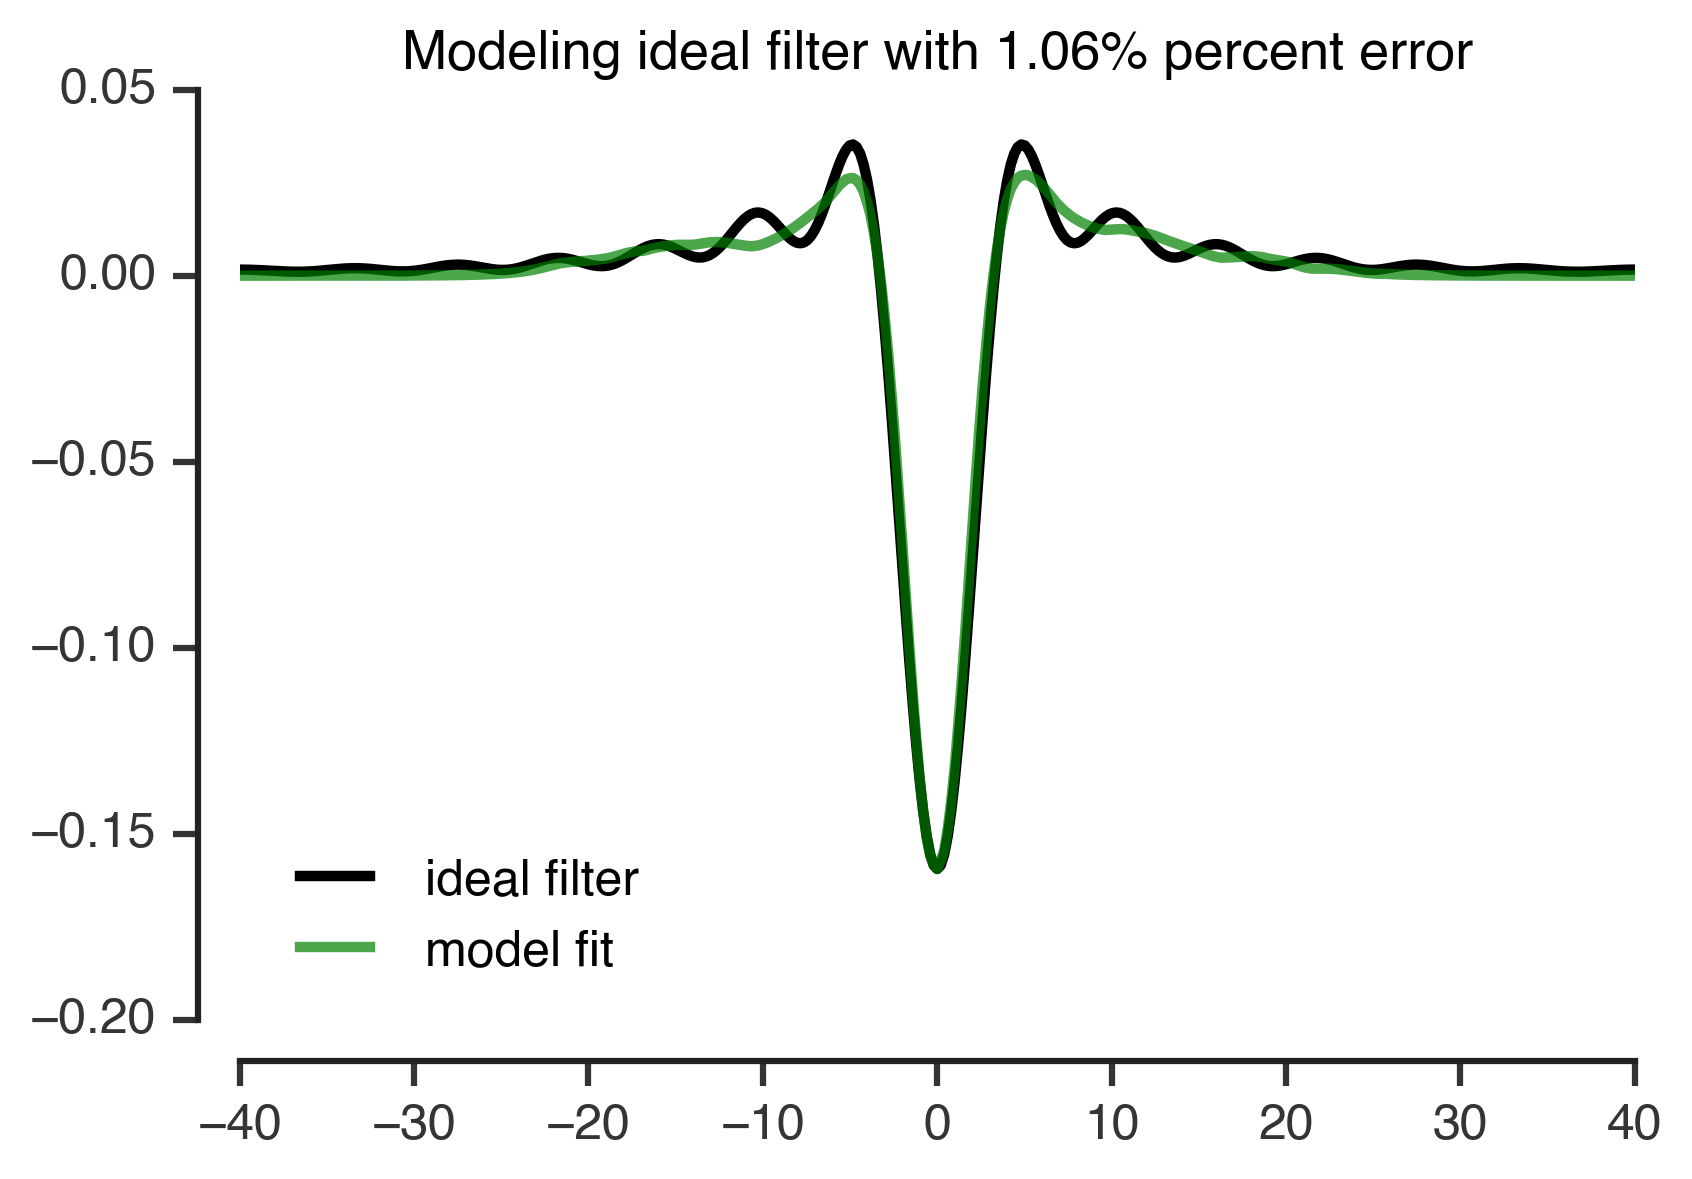

In [38]:
# plt.plot(space[:-1], -np.fft.fftshift(np.fft.irfft(ideal_filter)))
plt.plot(space, rf, 'k', label='ideal filter')
plt.plot(space, normed_rf, alpha=0.7, color='g', label='model fit')
plt.legend(frameon=False, loc='lower left', fontsize=12)

ideal_modeling_err = np.mean((normed_rf - rf)**2)/np.var(rf)
plt.title('Modeling ideal filter with %0.2f%% percent error' %(100*ideal_modeling_err), fontsize=13)
adjust_spines(plt.gca())

In [39]:
argmax_ha_weight = np.argmax(info_maps['medium_off_adapting'], axis=0)
argmax_cs_weight = np.argmax(info_maps['medium_off_adapting'], axis=1)
the_max = 0
for i in argmax_ha_weight:
    for j in argmax_cs_weight:
        if info_maps['medium_off_adapting'][i,j] > the_max:
            the_max = info_maps['medium_off_adapting'][i,j]
            print('axes (%d, %d) with %0.2f bits' %(i,j,the_max))

axes (0, 79) with 9.40 bits
axes (9, 79) with 9.41 bits


In [40]:
horz_weights[9]

0.060402684563758385

In [41]:
center_weights[79]

0.53020134228187921

In [42]:
ideal_fit = x
x

array([ 0.29645003,  0.53556595])

#### black star indicates ideal filter fit with model

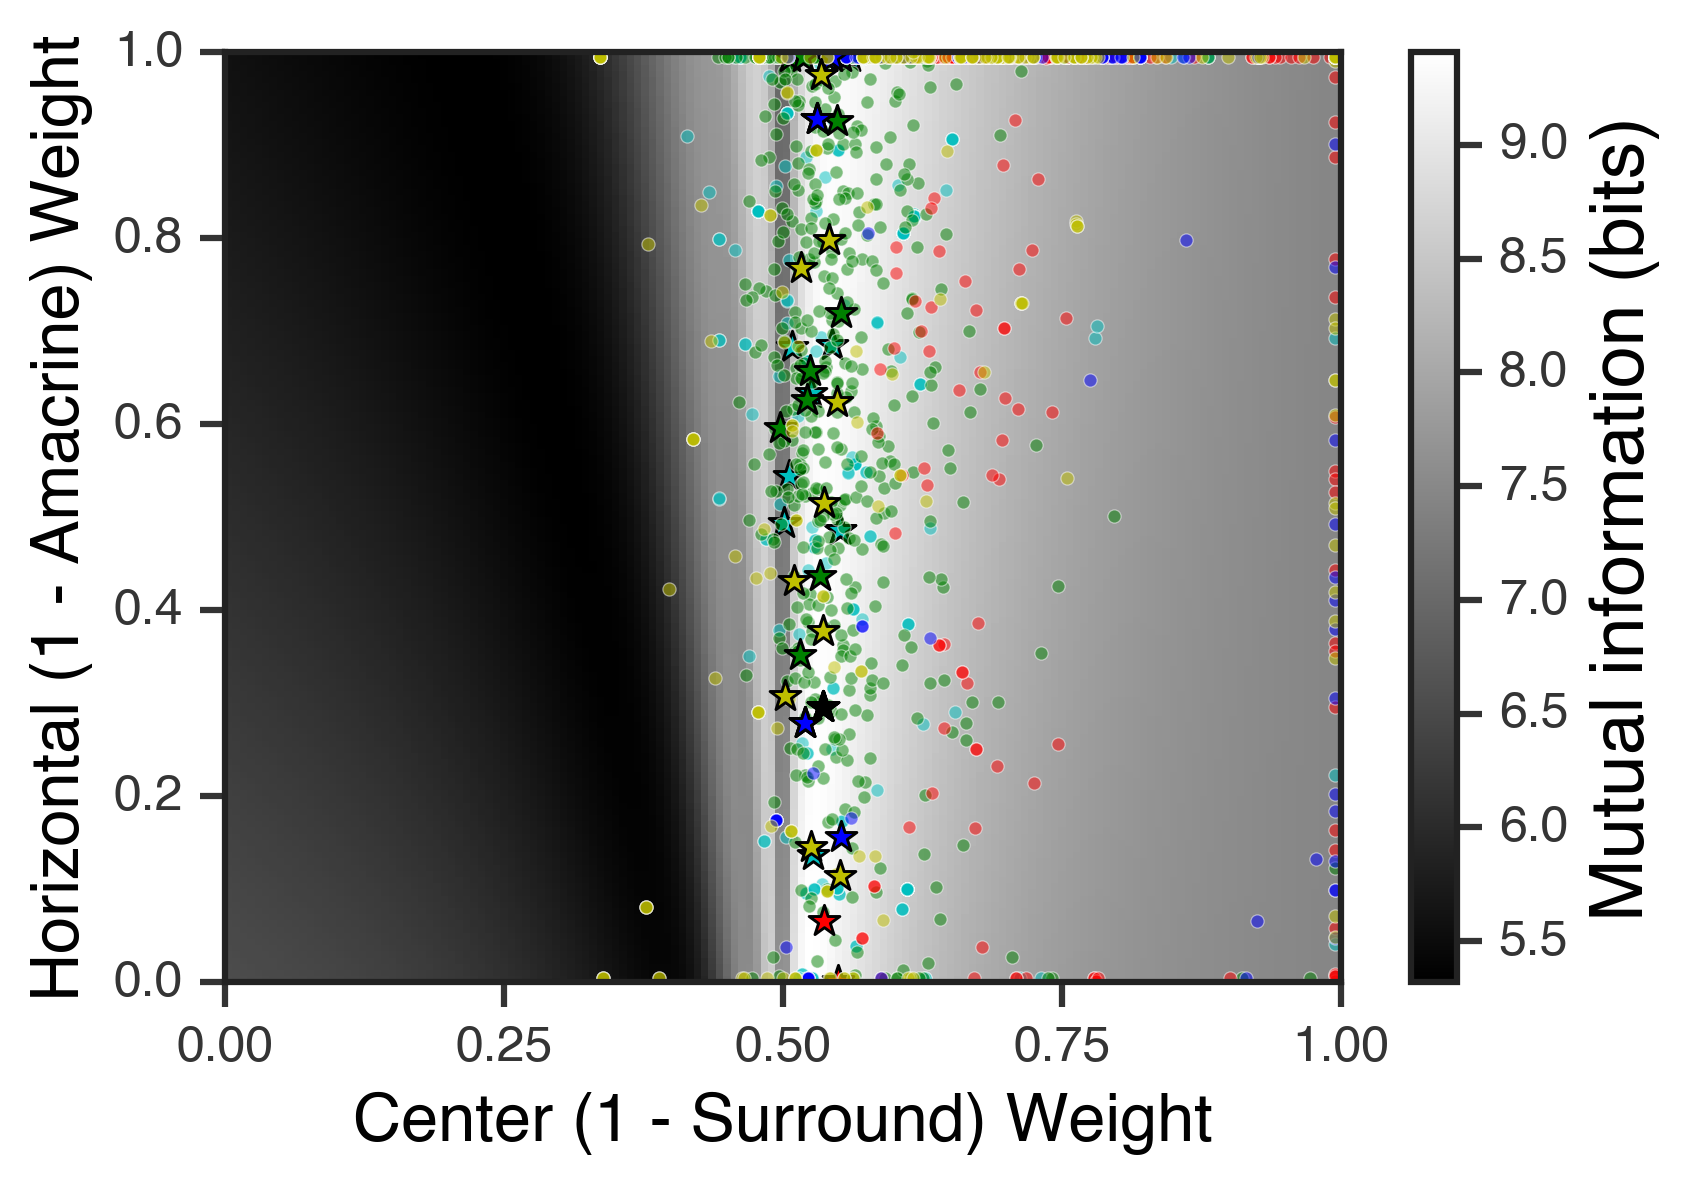

In [47]:
min_info = np.min(info_maps['medium_off_adapting'])
max_info = np.max(info_maps['medium_off_adapting'])
plt.imshow(info_maps['medium_off_adapting'], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)

for idc, celltype in enumerate([k for k in info_maps.keys() if k != 'ganglion']):
    # make the points lying on the edges more visible
    adjusted_fits1 = np.where(fits[celltype] == 1, 0.995, fits[celltype])
    adjusted_fits = np.where(adjusted_fits1 < 0.001, 0.005, adjusted_fits1)
    plt.scatter(adjusted_fits[:,1], adjusted_fits[:,0],
                c=colorscheme[celltype], edgecolor='w', s=10, alpha=0.5, label=' '.join(celltype.split('_')),
                linewidth=0.3)
    plt.scatter(adjusted_fits[example_ids[celltype]][:nexamples_for_this_plot,1],
               adjusted_fits[example_ids[celltype]][:nexamples_for_this_plot,0],
               c=colorscheme[celltype], edgecolor='k', s=60, marker='*', linewidth=0.7)
    plt.scatter(x[1], x[0], c='k', edgecolor='k', s=60, marker='*', linewidth=0.7)

# l = plt.legend(loc='upper left', frameon=False, fontsize=8)
# for text in l.get_texts():
#     text.set_color("white")
plt.ylim([0,1])
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.xlim([center_weights[0], center_weights[-1]])
# plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center (1 - Surround) Weight', fontsize=16)
plt.ylabel('Horizontal (1 - Amacrine) Weight', fontsize=16)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.savefig('information_and_ganglion_cells_v2 with examples more visible peak no title w bits with constrained noise with ideal point rerun 1-21.png')

# Get 1-d slice but with histogram of cell fits below

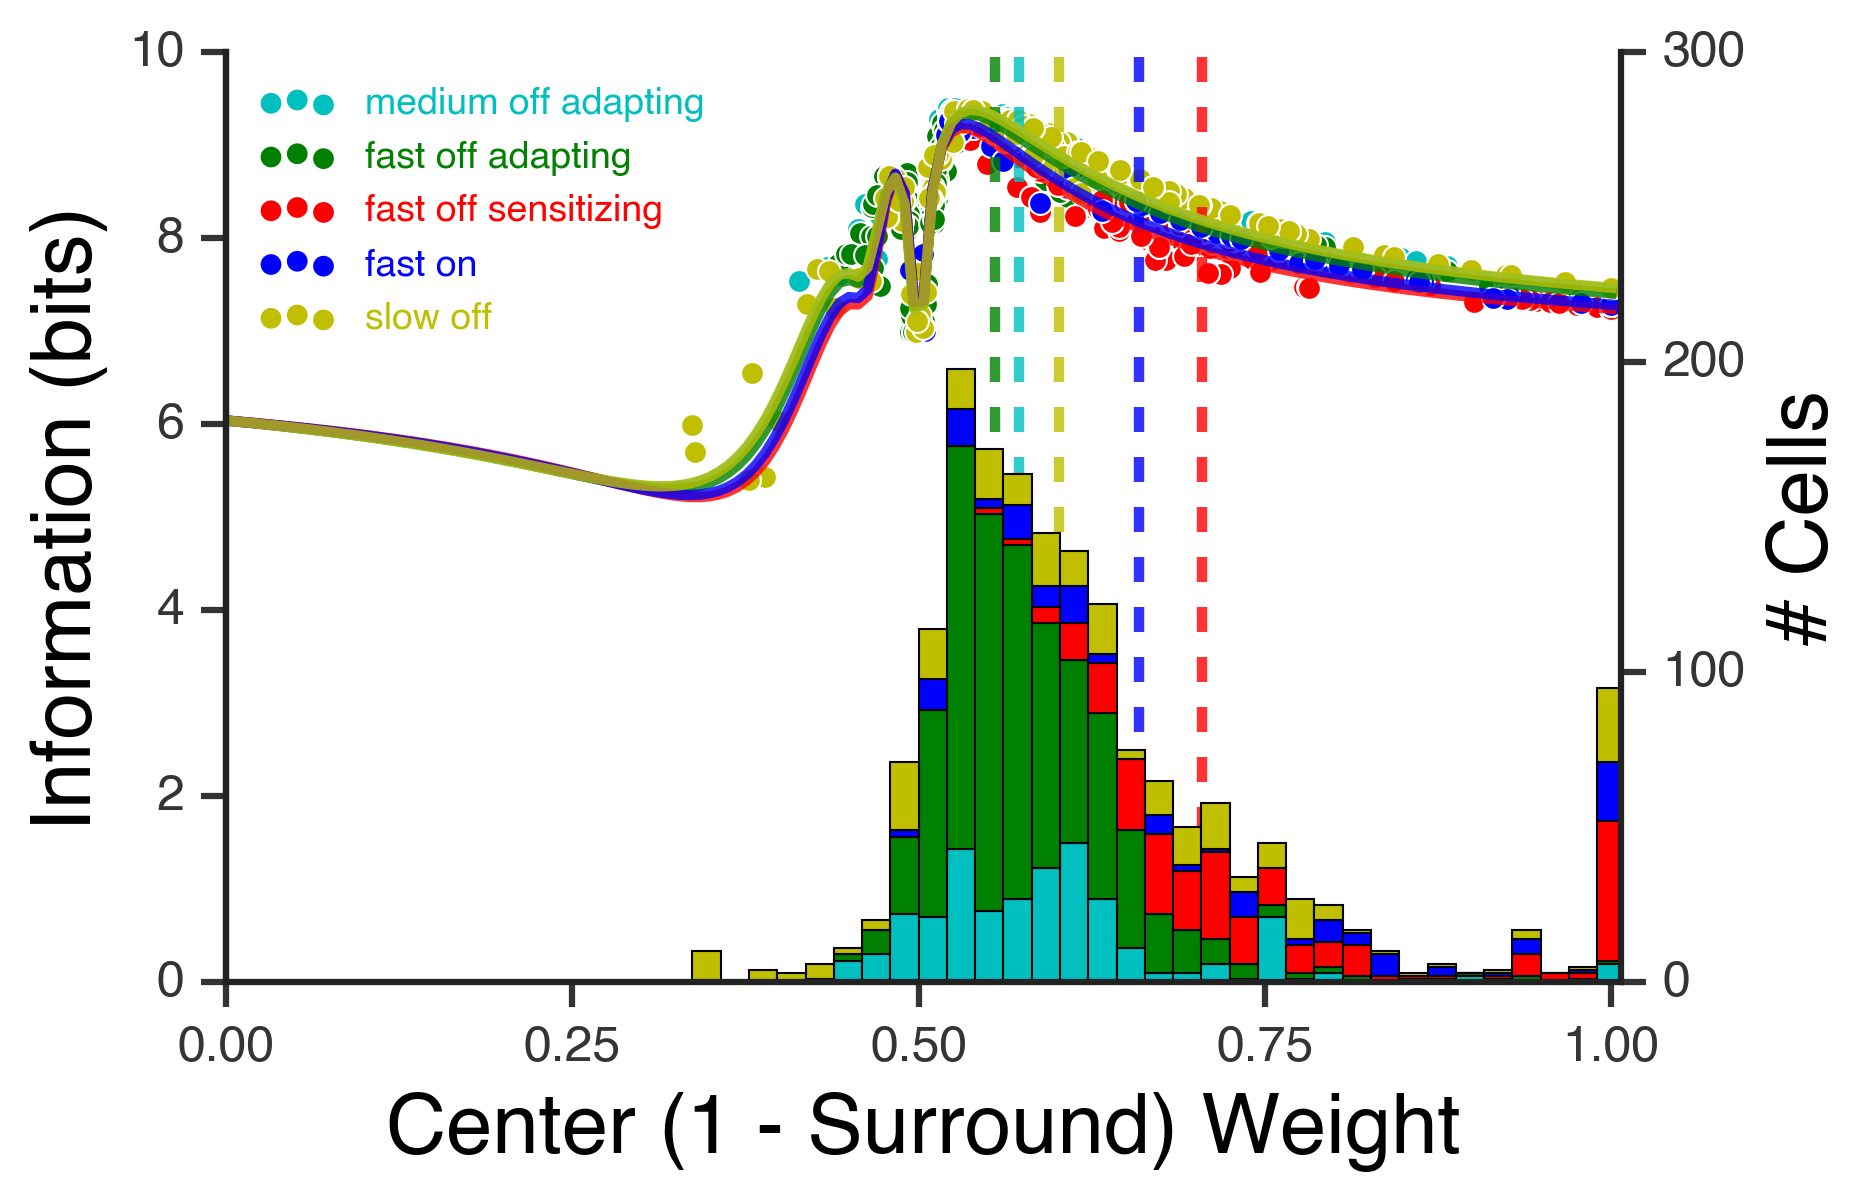

In [48]:
for c, celltype in enumerate(fits.keys()):
    if celltype != 'ganglion':
        plt.plot(center_weights, info_maps[celltype][75, :], alpha=0.8, color=colorscheme[celltype])
        infos_at_horz_slice = []
        center_weight_fits = np.stack(fits[celltype])[:, 1]
        for f in fits[celltype]:
            idx = np.argmin(abs(f[0] - horz_weights))
            idy = np.argmin(abs(f[1] - center_weights))
            infos_at_horz_slice.append(info_maps[celltype][idx, idy])

    #     color = np.random.rand(3)
        plt.scatter(center_weight_fits, infos_at_horz_slice, color=colorscheme[celltype], 
                    label=' '.join(celltype.split('_')), s=30, edgecolor='w', lw=0.5)
        plt.vlines(np.median(center_weight_fits), 0, 11, color=colorscheme[celltype], linestyle='--', alpha=0.8)
    
l = plt.legend(frameon=False, fontsize=9, loc='upper left')
for text in l.get_texts():
    splitlabel = text.properties()['text'].split(' ')
    text.set_color(colorscheme['_'.join(splitlabel)])

plt.ylabel('Information (bits)', fontsize=20)
# adjust_spines(plt.gca())
plt.ylim(0, 10)
plt.xlim(0,1.1)
ax1 = plt.gca()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.spines['bottom'].set_visible(False)
plt.xticks([])
ax1.set_xlabel('Center (1 - Surround) Weight', fontsize=20)

# Histogram
bin_edges = np.linspace(0, 1, 50)
bin_width = np.mean(np.diff(bin_edges))
prev_count = np.zeros_like(bin_edges[:-1])

ax2 = ax1.twinx()
for c, celltype in enumerate(fits.keys()):
    if celltype != 'ganglion':
        this_count, bins = np.histogram(np.stack(fits[celltype])[:, 1], bins=bin_edges)
        ax2.bar(bin_edges[:-1] + bin_width/2, this_count, color=colorscheme[celltype], width=bin_width,
               bottom=prev_count, linewidth=0.5)
        prev_count += this_count

plt.xlim(0,1.007)
plt.xticks([0, 0.25, 0.5, 0.75, 1])
ax2.set_ylabel('# Cells', color='k', fontsize=20)
ax2.set_ylim(0,300)
ax2.set_yticks([0,100,200,300])

# ax.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.xaxis.set_ticks_position('bottom')

# ax.yaxis.set_ticks_position('left')
# adjust_spines(plt.gca())
# plt.xlabel('Center (1 - surround) weight')
# plt.ylabel('# Cells')
plt.savefig('1d info slice with histogram with constrained noise rerun 1-21.png')

# Histograms of pairwise ganglion diversity

In [49]:
radians_to_deg = 360./(2*np.pi)

In [50]:
def angle(rf1, rf2):
    a = np.arccos(np.inner(rf1, rf2)/(np.sqrt(np.sum(rf1**2)) * np.sqrt(np.sum(rf2**2))))
    return radians_to_deg * np.min([a, abs(a - 2*np.pi)])

# simple variance measure

In [68]:
variance_directions = collections.defaultdict(list)
for celltype in fits.keys():
    these_fits = fits[celltype]
    
    # fit pca to this variance
    pca = PCA(n_components=2)
    pca.fit(these_fits)
    
    # flipping the dimensions because fits was saved as horz_weight, center_weight
    variance_directions[celltype] = abs(np.array([pca.components_[0][1], pca.components_[0][0]]))
    print('PC1 has explained variance %0.2f%% percent for %s' %(pca.explained_variance_ratio_[0]*100, celltype))


PC1 has explained variance 91.91% percent for medium_off_adapting
PC1 has explained variance 95.07% percent for fast_off_adapting
PC1 has explained variance 85.12% percent for fast_off_sensitizing
PC1 has explained variance 82.28% percent for fast_on
PC1 has explained variance 83.64% percent for slow_off
PC1 has explained variance 76.42% percent for ganglion


In [69]:
variance_directions

defaultdict(list,
            {'fast_off_adapting': array([ 0.01224762,  0.999925  ]),
             'fast_off_sensitizing': array([ 0.0283226 ,  0.99959883]),
             'fast_on': array([ 0.00492854,  0.99998785]),
             'ganglion': array([ 0.08594923,  0.99629952]),
             'medium_off_adapting': array([ 0.05372578,  0.99855573]),
             'slow_off': array([ 0.18184338,  0.98332751])})

In [70]:
np.var(these_fits, axis=0)

array([ 0.06317005,  0.01991079])

### compute direction of maximum variance for the average cell

In [71]:
all_fits = []
for celltype in fits.keys():
    all_fits.extend(fits[celltype])
    
pca = PCA(n_components=2)
pca.fit(all_fits)

# flipping the dimensions because fits was saved as horz_weight, center_weight
average_variance_direction = abs(np.array([pca.components_[0][1], pca.components_[0][0]]))
print('PC1 has explained variance %0.2f%% percent for all cells' %(pca.explained_variance_ratio_[0]*100))

PC1 has explained variance 85.58% percent for all cells


In [72]:
average_variance_direction

array([ 0.06541452,  0.99785818])

### compute direction of least information change for all cells, and then average  
Do this by selecting top 95% info maps (x,y) points and doing PCA on that cloud

In [73]:
info_maps['medium_off_adapting'].shape

(150, 150)

In [74]:
max_info_coordinates = collections.defaultdict(list)
least_info_directions = collections.defaultdict(list)
for celltype in info_maps.keys():
    for x in range(info_maps[celltype].shape[0]):
        for y in range(info_maps[celltype].shape[1]):
            # take cloud of high efficiency points
            if info_maps[celltype][x,y] >= 0.95*max_info:
                max_info_coordinates[celltype].append([horz_weights[x], center_weights[y]])
    pca = PCA()
    pca.fit(max_info_coordinates[celltype])
    print('PC1 has explained variance %0.2f%% percent for %s' %(pca.explained_variance_ratio_[0]*100, celltype))
    least_info_directions[celltype] = abs(pca.components_[-1])

PC1 has explained variance 99.34% percent for medium_off_adapting
PC1 has explained variance 99.46% percent for fast_off_adapting
PC1 has explained variance 99.75% percent for fast_off_sensitizing
PC1 has explained variance 99.69% percent for fast_on
PC1 has explained variance 99.32% percent for slow_off
PC1 has explained variance 99.09% percent for ganglion


In [75]:
least_info_directions

defaultdict(list,
            {'fast_off_adapting': array([ 0.02687228,  0.99963888]),
             'fast_off_sensitizing': array([ 0.02620944,  0.99965647]),
             'fast_on': array([ 0.02673362,  0.99964259]),
             'ganglion': array([ 0.02800431,  0.9996078 ]),
             'medium_off_adapting': array([ 0.02689528,  0.99963826]),
             'slow_off': array([ 0.02679882,  0.99964085])})

### ax.quiver plot showing all of these vectors

In [81]:
variance_directions[celltype][1]

0.053725779558951532

(-0.01, 1.01)

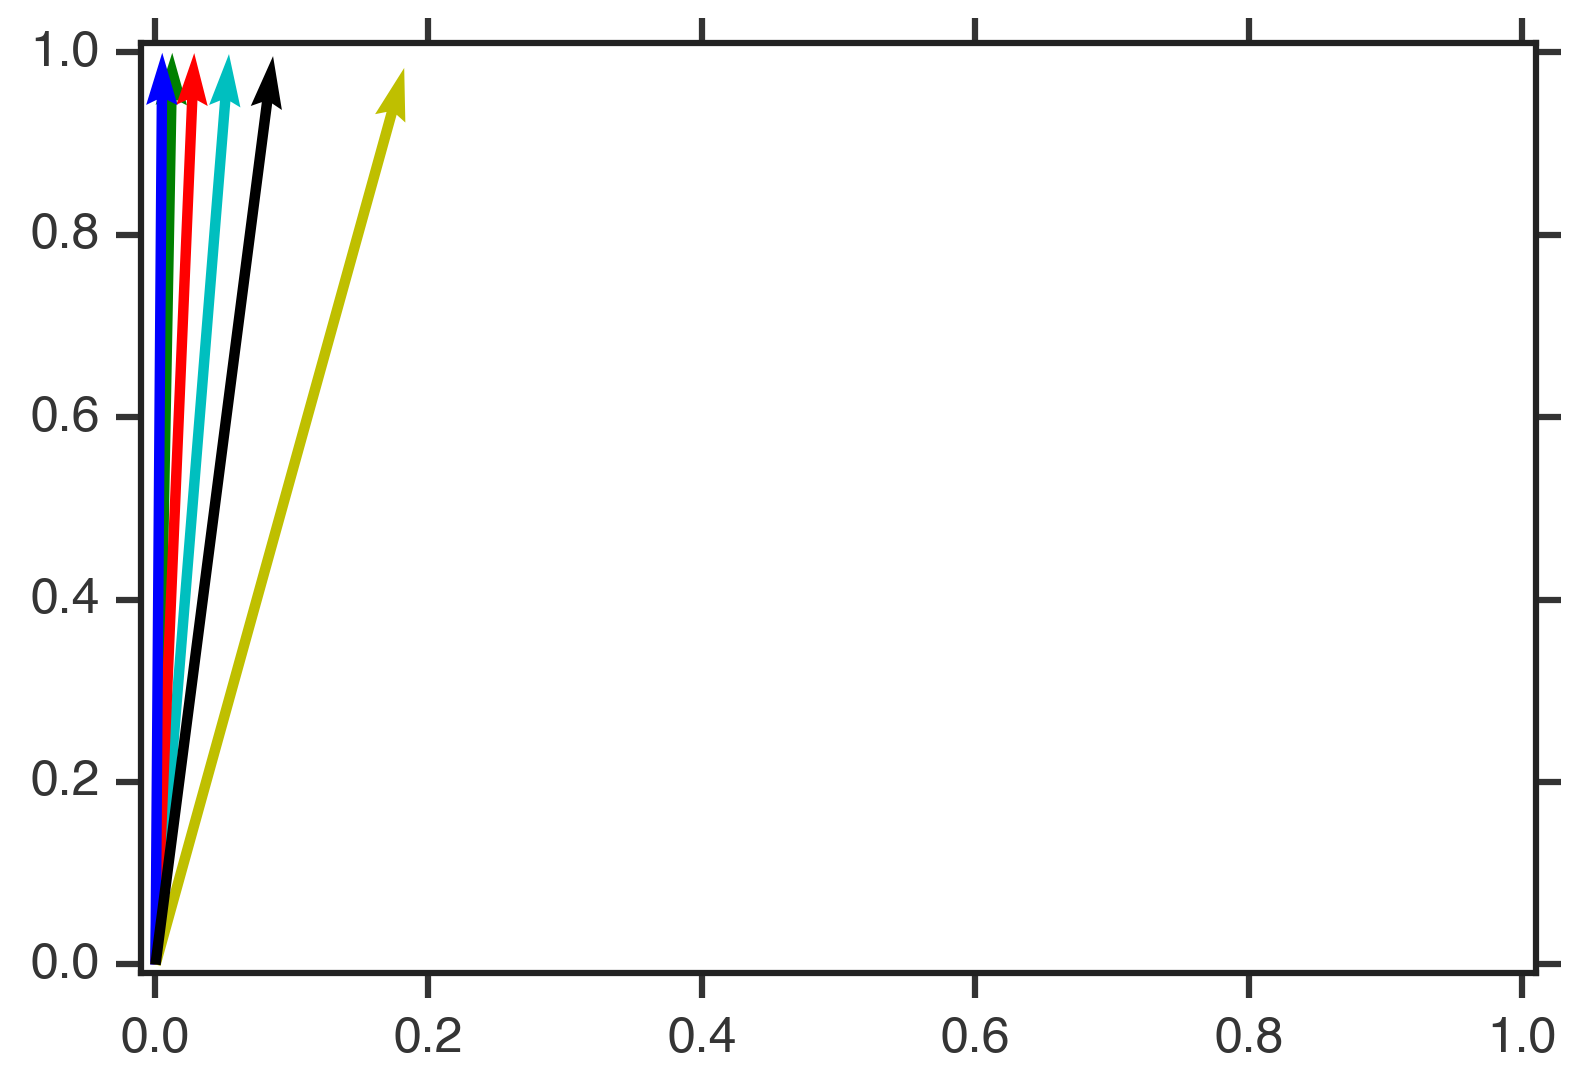

In [92]:
for celltype in variance_directions.keys():
    plt.quiver(0, 0, variance_directions[celltype][0], variance_directions[celltype][1],
               angles='xy', scale_units='xy', scale=1, color=colorscheme[celltype])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
# adjust_spines(plt.gca())

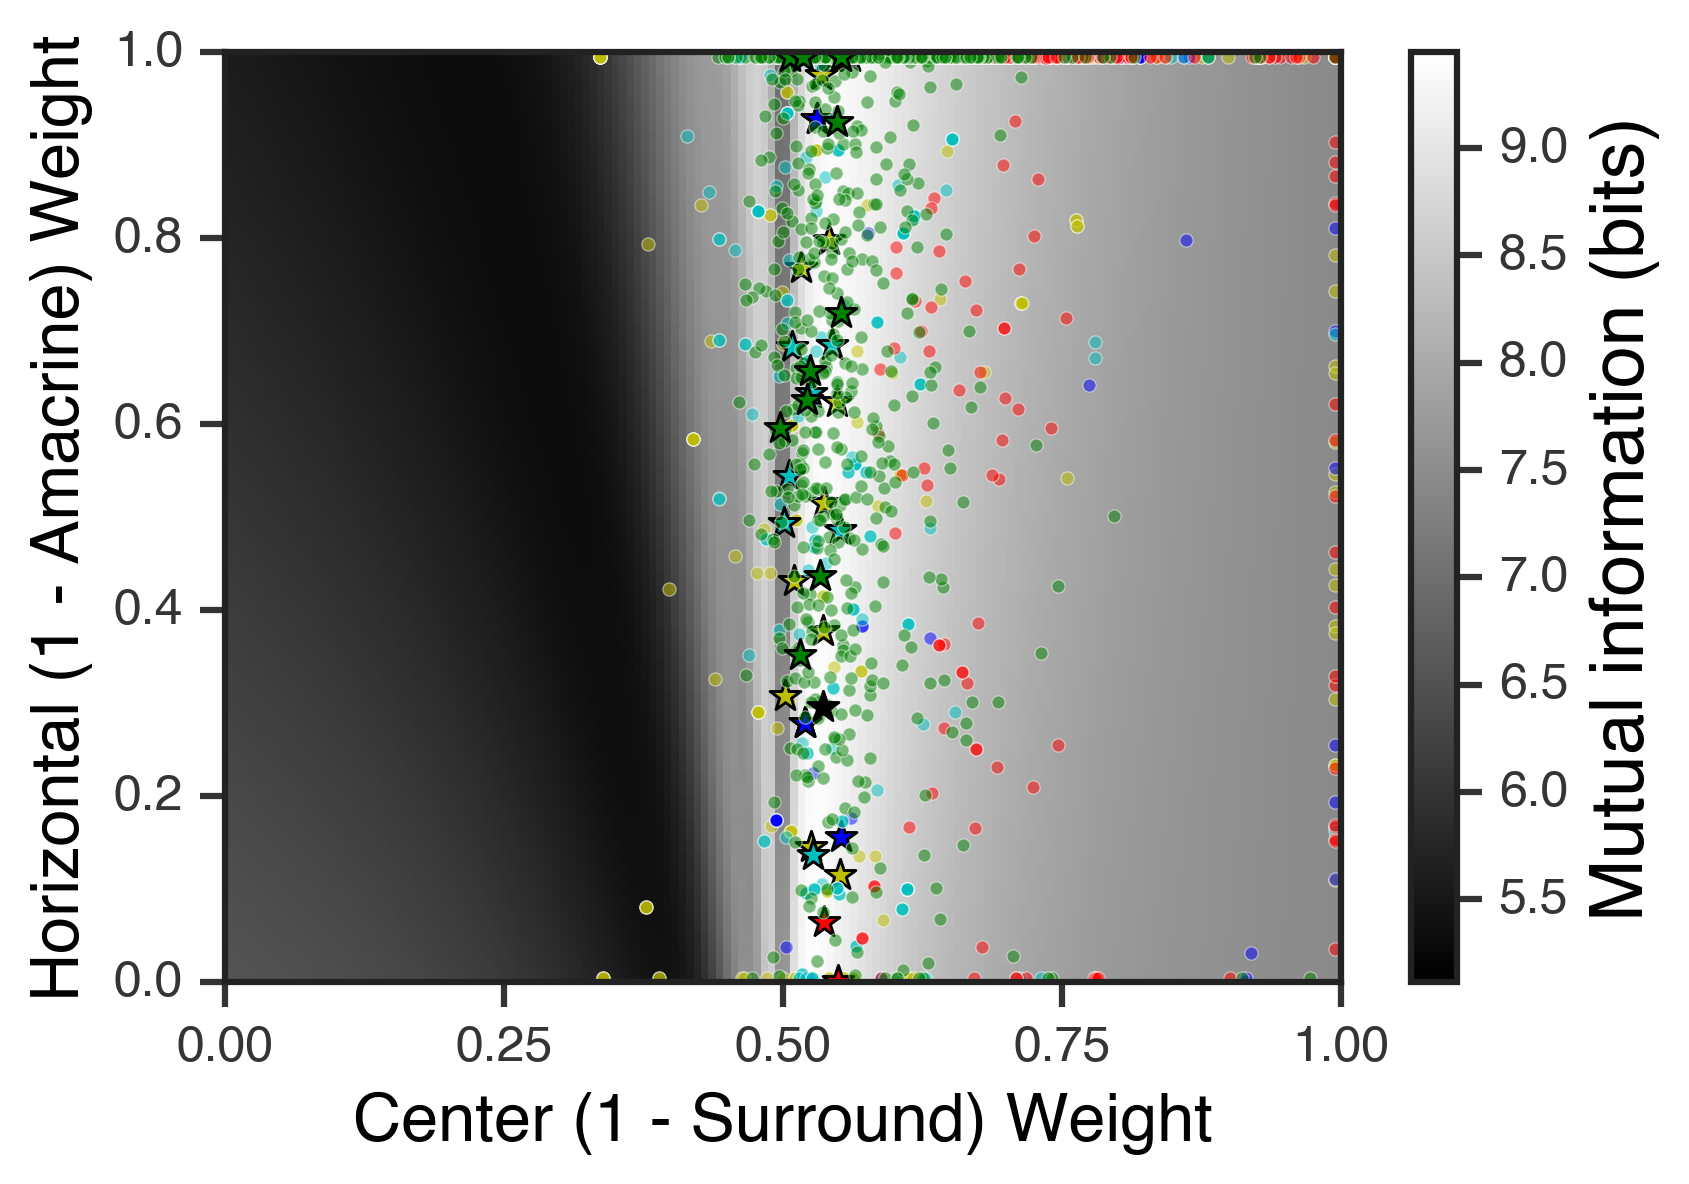

In [665]:
plt.imshow(info_maps['medium_off_adapting'], extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
              aspect='auto', clim=[min_info, max_info])
cbar = plt.colorbar()
# plt.clim(0,np.max(info_color_map))
cbar.ax.set_ylabel('Mutual information (bits)', fontsize=18)

for idc, celltype in enumerate([k for k in info_maps.keys() if k != 'ganglion']):
    # make the points lying on the edges more visible
    adjusted_fits1 = np.where(fits[celltype] == 1, 0.995, fits[celltype])
    adjusted_fits = np.where(adjusted_fits1 < 0.001, 0.005, adjusted_fits1)
    plt.scatter(adjusted_fits[:,1], adjusted_fits[:,0],
                c=colorscheme[celltype], edgecolor='w', s=10, alpha=0.5, label=' '.join(celltype.split('_')),
                linewidth=0.3)
    plt.scatter(adjusted_fits[example_ids[celltype]][:nexamples_for_this_plot,1],
               adjusted_fits[example_ids[celltype]][:nexamples_for_this_plot,0],
               c=colorscheme[celltype], edgecolor='k', s=60, marker='*', linewidth=0.7)
plt.scatter(ideal_fit[1], ideal_fit[0], c='k', edgecolor='k', s=60, marker='*', linewidth=0.7)

# l = plt.legend(loc='upper left', frameon=False, fontsize=8)
# for text in l.get_texts():
#     text.set_color("white")
plt.ylim([0,1])
plt.xticks([0, 0.25, 0.5, 0.75, 1])
plt.xlim([center_weights[0], center_weights[-1]])
# plt.title('Total information of various models \n with fitted ganglion cells', fontsize=16)
plt.xlabel('Center (1 - Surround) Weight', fontsize=16)
plt.ylabel('Horizontal (1 - Amacrine) Weight', fontsize=16)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
# plt.savefig('information_and_ganglion_cells_v2 with examples more visible peak no title w bits with constrained noise with ideal point rerun 1-21.png')